# VQO of the Magic Squares Game

In this notebook, we demonstrate the use of variational quantum optimization (VQO) to find optimal quantum strategies for the magic square game.

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt

from context import QNetOptimizer as QNopt

## Finding the Perfect Winning Probability

The optimal quantum strategy is described in https://arxiv.org/abs/quant-ph/0407221.
The magic squares cost function minimizes $-P_{Win}$ and is outlined in more detail in the `QNetOptimizer` docs.

### Optimizing Measurments for Fixed State Preparations

In this section, we will optimize arbitrary two-qubit measurements against different state preparations including, a 4-qubit GHZ state, two copies of a Bell state, a single Bell state, and no entanglement.
Each optimization will be performed on 4-qubit wires.

In [2]:
wires = [0,1,2,3]
bell_copies_prep_node = [QNopt.PrepareNode(1, wires, QNopt.bell_state_copies, 0)]
ghz_prep_node = [QNopt.PrepareNode(1, wires, QNopt.ghz_state, 0)]
bell_state_prep_node = [QNopt.PrepareNode(1, wires, lambda settings, wires: QNopt.ghz_state([], [wires[0], wires[2]]), 0)]
classical_prep_node = [QNopt.PrepareNode(1, wires, lambda settings, wires: None, 0)]

measure_nodes = [
    QNopt.MeasureNode(3,4, wires[0:2], qml.templates.subroutines.ArbitraryUnitary, 15),
    QNopt.MeasureNode(3,4, wires[2:], qml.templates.subroutines.ArbitraryUnitary, 15),
]

bell_copies_ansatz = QNopt.NetworkAnsatz(bell_copies_prep_node, measure_nodes)
ghz_state_ansatz = QNopt.NetworkAnsatz(ghz_prep_node, measure_nodes)
bell_state_ansatz = QNopt.NetworkAnsatz(bell_state_prep_node, measure_nodes)
classical_ansatz = QNopt.NetworkAnsatz(classical_prep_node, measure_nodes)

Next, we perform gradient descent to minimze the magic squares cost function with respect to each of the above state preparations.

In [3]:
%%time
np.random.seed(1)

bell_copies_opt_dict = QNopt.gradient_descent(
    QNopt.magic_squares_game_cost(bell_copies_ansatz),
    bell_copies_ansatz.rand_scenario_settings(),
    step_size=3.5,
    num_steps=100,
    sample_width=5,
    verbose=False
)

print("opt score : ", bell_copies_opt_dict["opt_score"])

opt score :  0.9999370753948471
CPU times: user 25.5 s, sys: 198 ms, total: 25.7 s
Wall time: 26.8 s


In [11]:
%%time
np.random.seed(2)

ghz_state_opt_dict = QNopt.gradient_descent(
    QNopt.magic_squares_game_cost(ghz_state_ansatz),
    ghz_state_ansatz.rand_scenario_settings(),
    step_size=3.5,
    num_steps=100,
    sample_width=5,
    verbose=False
)

print("opt score : ", ghz_state_opt_dict["opt_score"])

opt score :  0.955244701837105
CPU times: user 50.3 s, sys: 381 ms, total: 50.7 s
Wall time: 51 s


In [5]:
%%time
np.random.seed(1)

bell_state_opt_dict = QNopt.gradient_descent(
    QNopt.magic_squares_game_cost(bell_state_ansatz),
    bell_state_ansatz.rand_scenario_settings(),
    step_size=3.5,
    num_steps=100,
    sample_width=5,
    verbose=False
)

print("opt score : ", bell_state_opt_dict["opt_score"])

opt score :  0.9553331636852991
CPU times: user 28.9 s, sys: 408 ms, total: 29.3 s
Wall time: 29.9 s


In [6]:
%%time
np.random.seed(1)

classical_opt_dict = QNopt.gradient_descent(
    QNopt.magic_squares_game_cost(classical_ansatz),
    classical_ansatz.rand_scenario_settings(),
    step_size=3.5,
    num_steps=100,
    sample_width=5,
    verbose=False
)

print("opt score : ", classical_opt_dict["opt_score"])

opt score :  0.8888835591017996
CPU times: user 27.4 s, sys: 318 ms, total: 27.7 s
Wall time: 28 s


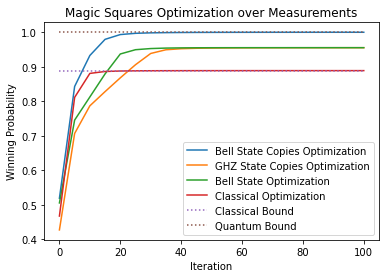

In [12]:
num_samples = len(bell_copies_opt_dict["scores"])
sample_width = 5
x_ticks = np.arange(num_samples) *  sample_width

plt.plot(x_ticks, bell_copies_opt_dict["scores"], label = "Bell State Copies Optimization")
plt.plot(x_ticks, ghz_state_opt_dict["scores"], label = "GHZ State Copies Optimization")
plt.plot(x_ticks, bell_state_opt_dict["scores"], label = "Bell State Optimization")
plt.plot(x_ticks, classical_opt_dict["scores"], label = "Classical Optimization")

plt.plot(x_ticks, [8/9] * num_samples, label = r"Classical Bound", linestyle=":")
plt.plot(x_ticks, [1] * num_samples, label = "Quantum Bound", linestyle=":")

plt.title("Magic Squares Optimization over Measurements")
plt.xlabel("Iteration")
plt.ylabel("Winning Probability")
plt.legend()
plt.show()

### Finding Optimal Quantum States and Measurements for the Magic Square Game

In this section, we use VQO to find a quantum state and measurements that win the magic squares game with perfect probability.

In [13]:
%%time

np.random.seed(3) # susceptible to local minima

arb_prep_node = [QNopt.PrepareNode(1,wires,qml.templates.subroutines.ArbitraryUnitary, 255)]
arb_ansatz = QNopt.NetworkAnsatz(arb_prep_node, measure_nodes)

arb_opt_dict = QNopt.gradient_descent(
    QNopt.magic_squares_game_cost(arb_ansatz),
    arb_ansatz.rand_scenario_settings(),
    step_size=0.4,
    num_steps=100,
    sample_width=5
)

print("opt score : ", arb_opt_dict["opt_score"])

iteration :  0 , score :  0.553554017010692
iteration :  5 , score :  0.7514047404800869
iteration :  10 , score :  0.7873829964863325
iteration :  15 , score :  0.8139069793663322
iteration :  20 , score :  0.834927928706339
iteration :  25 , score :  0.8523477546913936
iteration :  30 , score :  0.8672793089000949
iteration :  35 , score :  0.8805744660808168
iteration :  40 , score :  0.8929519961236915
iteration :  45 , score :  0.9049514378133267
iteration :  50 , score :  0.9168186340729242
iteration :  55 , score :  0.9284228285741669
iteration :  60 , score :  0.9393313808101998
iteration :  65 , score :  0.9490617029581043
iteration :  70 , score :  0.9573360724856516
iteration :  75 , score :  0.9641514410589794
iteration :  80 , score :  0.9696834941084485
iteration :  85 , score :  0.9741638991293922
iteration :  90 , score :  0.9778084852376779
iteration :  95 , score :  0.980793814521591
opt score :  0.9832574633511538
CPU times: user 10min 51s, sys: 10.7 s, total: 11min 

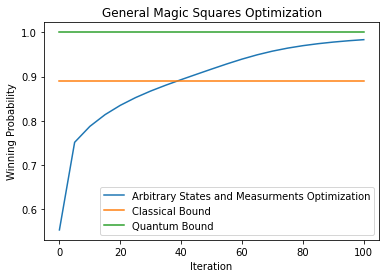

In [14]:
sample_width = 5
num_samples = len(arb_opt_dict["scores"])
x_ticks = np.arange(num_samples) * sample_width

plt.plot(x_ticks, arb_opt_dict["scores"] , label = "Arbitrary States and Measurments Optimization")
plt.plot(x_ticks, [8/9]*num_samples, label = r"Classical Bound")
plt.plot(x_ticks, [1]*num_samples, label = "Quantum Bound")
plt.title("General Magic Squares Optimization")
plt.xlabel("Iteration")
plt.ylabel("Winning Probability")
plt.legend()
plt.show()